In [1]:
%load_ext autoreload
%autoreload 2

This notebook is used to construct a `SeriesPipeline` which aims to detect whether a wearable is on the wrist or not.

In [2]:
import sys

import numpy as np
import pandas as pd

sys.path.append("../../")

import plotly.graph_objects as go
from functional import seq

from code_utils.path_conf import processed_mbrain_path, mbrain_metadata_path, figure_dir
from code_utils.empatica.nonwear import wrist_pipeline, wrist_pipeline_bottcher

from plotly.subplots import make_subplots
from plotly_resampler import FigureResampler, FigureWidgetResampler
from tsflex.processing import get_processor_logs

USE_PNG = True

We define two wearable-non-wear detection pipelines for the Empatica E4

- The non-wear pipeline of [Böttcher et al., 2022](https://www.nature.com/articles/s41598-022-25949-x)
- our revised iteration of this pipeline 

## Backtest the non-wear detection pipeline on an excerpt

### Our pipeline

In [3]:
user = 'MBRAIN21-004'
user_s = f"{user}.empatica.E4.A02FFD"
date_s = "2021_10_17"
off_wrist_start_end = '22:02:20', '22:15:14'

In [4]:
# Read the wearable data
df_eda = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"gsr_{date_s}*"))[0]
).set_index("timestamp")
df_acc = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"acc_{date_s}*"))[0]
).set_index("timestamp")
df_tmp = pd.read_parquet(
    list(processed_mbrain_path.joinpath(user_s).glob(f"tmp_{date_s}*"))[0]
).set_index("timestamp")

# Get the off-wrist start and end timestamps (manually labeled)
off_wrist_start_end_ts = df_acc.between_time(*off_wrist_start_end)
off_wrist_start_end_ts = off_wrist_start_end_ts.index[0], off_wrist_start_end_ts.index[-1]

# df_bvp = pd.read_parquet(
#     list(obelisk_dir.joinpath(user_s).glob(f"bvp_{date_s}*"))[0]
# ).set_index("timestamp")

if True:
    last_td_str = "3h"
    first_td_str = "1h"
    df_eda = df_eda.last(last_td_str).first(first_td_str)
    df_acc = df_acc.last(last_td_str).first(first_td_str)
    df_tmp = df_tmp.last(last_td_str).first(first_td_str)


out = wrist_pipeline.process(
    [df_eda, df_acc, df_tmp],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)
# display(out.head(3))


/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning: Logging file (wrist_on_off_.log) already exists. This file will be overwritten!
  warnings.warn(


,function,series_names,duration
0,<lambda>,"(ACC_x,)",0 days 00:00:00.002142191
1,<lambda>,"(EDA,)",0 days 00:00:00.000187874
2,<lambda>,"(TMP,)",0 days 00:00:00.000169754
3,<lambda>,"(AI,)",0 days 00:00:00.000159740
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.000788689
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:00.000651121
6,sqi_or,"(EDA_SQI, TMP_SQI, AI_SQI)",0 days 00:00:00.000332355
7,sqi_smoothen,"(On_Wrist_SQI,)",0 days 00:00:00.000846148
8,sqi_smoothen,"(On_Wrist_SQI_smoothened,)",0 days 00:00:00.000849247


0.00613 seconds per hour


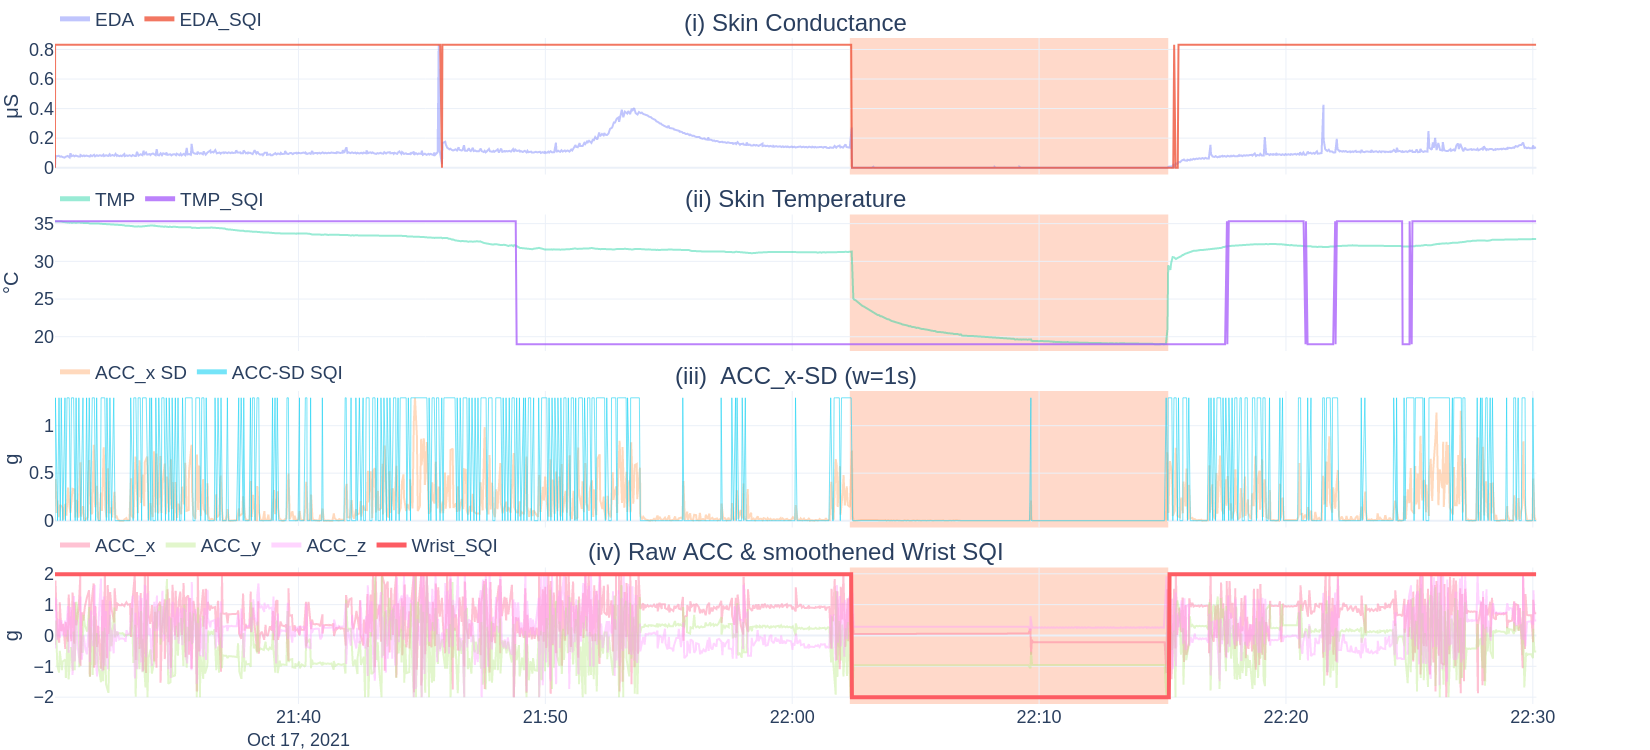

In [5]:
n_rows = 4
if True:
    specs = [[{"secondary_y": True}] for _ in range(n_rows)]
    fig = FigureResampler(
        make_subplots(
            rows=n_rows,
            specs=np.reshape(specs, (-1, 1)).tolist(),
            vertical_spacing=0.06,
            cols=1,
            shared_xaxes=True,
            subplot_titles=[
                "(i) Skin Conductance",
                "(ii) Skin Temperature",
                "(iii)  ACC_x-SD (w=1s)",
                "(iv) Raw ACC & smoothened Wrist SQI",
            ],
        ),
        show_mean_aggregation_size=False,
        resampled_trace_prefix_suffix=("", ""),
    )

# ROW 1 -----------------------------------------------------

for col in df_eda.columns:
    s_c = df_eda[col]
    fig.add_trace(go.Scatter(name=col, opacity=0.4), hf_x=s_c.index, hf_y=s_c)

for col in ["EDA_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
    )

# ROW 2 -----------------------------------------------------
for col in df_tmp.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, legend="legend2"),
        hf_x=df_tmp[col].index,
        hf_y=df_tmp[col],
        row=2,
        col=1,
    )


for col in ["TMP_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8, legend="legend2"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
        secondary_y=True,
    )

# ROW 3 -----------------------------------------------------
for col in ["AI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(opacity=0.4, name="ACC_x SD", legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c,
        row=3,
        col=1,
    )

for col in ["AI_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name="ACC-SD SQI", opacity=0.6, line_width=1, legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        row=3,
        col=1,
    )


# ROW 4 -----------------------------------------------------
for col in df_acc.columns:
    fig.add_trace(
        go.Scatter(name=f"{col}", opacity=0.4, legend="legend4"),
        hf_x=df_acc[col].index,
        hf_y=df_acc[col] / 64,
        row=4,
        col=1,
    )

for col in ["Wrist_SQI", "On_Wrist_SQI_smoothened"][1:]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name="Wrist_SQI", line_color="#fd5c63", line_width=4, legend="legend4"
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=4,
        col=1,
        secondary_y=True,
    )


# ROW 5 -----------------------------------------------------
# for col in df_bvp.columns:
#     s_c = df_bvp[col]
#     fig.add_trace(
#         go.Scatter(name=col, opacity=0.5), hf_x=s_c.index, hf_y=s_c, row=5, col=1
#     )


# add a shaded rectangle to the off-wrist period
fig.add_vrect(
    x0=off_wrist_start_end_ts[0],
    x1=off_wrist_start_end_ts[1],
    fillcolor="lightsalmon",
    opacity=0.4,
    line_width=0,
    layer="below",
    row="all",
    col=1,
)

# ---------------------- LAYOUT --------------------------------
fig.update_layout(template="plotly_white", height=750)
fig.update_layout(
    legend=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=1.0, x=0, itemsizing="constant"),
    ),
    legend2=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.73, x=0, itemsizing="constant"),
    ),
    legend3=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.47, x=0, itemsizing="constant"),
    ),
    legend4=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.21, x=0, itemsizing="constant"),
    ),
)
fig.update_yaxes(title_text="μS", row=1, col=1, title_font_size=20)
fig.update_yaxes(title_text="°C", row=2, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=3, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=4, col=1, title_font_size=20)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_annotations(font_size=24)
# update tick sizes
fig.update_xaxes(tickfont_size=18)
fig.update_yaxes(tickfont_size=18)
# do not show seconds on the y-axis
fig.update_yaxes(visible=False, secondary_y=True)

# fig.show_dash(mode="inline", port=9035)
if USE_PNG:
    fig.show(renderer="png", width=1650, height=750)
fig.write_html(figure_dir / "wrist_on_off.html", include_plotlyjs="cdn", full_html=False)

### Böttcher

In [6]:
out_bottcher = wrist_pipeline_bottcher.process(
    [df_eda, df_tmp, df_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(df_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)


/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning:

Logging file (wrist_on_off_.log) already exists. This file will be overwritten!



,function,series_names,duration
0,dataframe_func: std_sum,"(ACC_x, ACC_y, ACC_z)",0 days 00:00:00.015434504
1,<lambda>,"(AI,)",0 days 00:00:00.000271797
2,<lambda>,"(EDA,)",0 days 00:00:00.000189304
3,<lambda>,"(TMP,)",0 days 00:00:00.000420332
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.000778437
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:00.002783060
6,mean_resample,"(EDA_SQI,)",0 days 00:00:00.004436255
7,mean_resample,"(AI_SQI,)",0 days 00:00:00.001044512
8,mean_resample,"(TMP_SQI,)",0 days 00:00:00.001032829
9,mean_resample,"(EDA_SQI,)",0 days 00:00:00.001026868


0.03091 seconds per hour


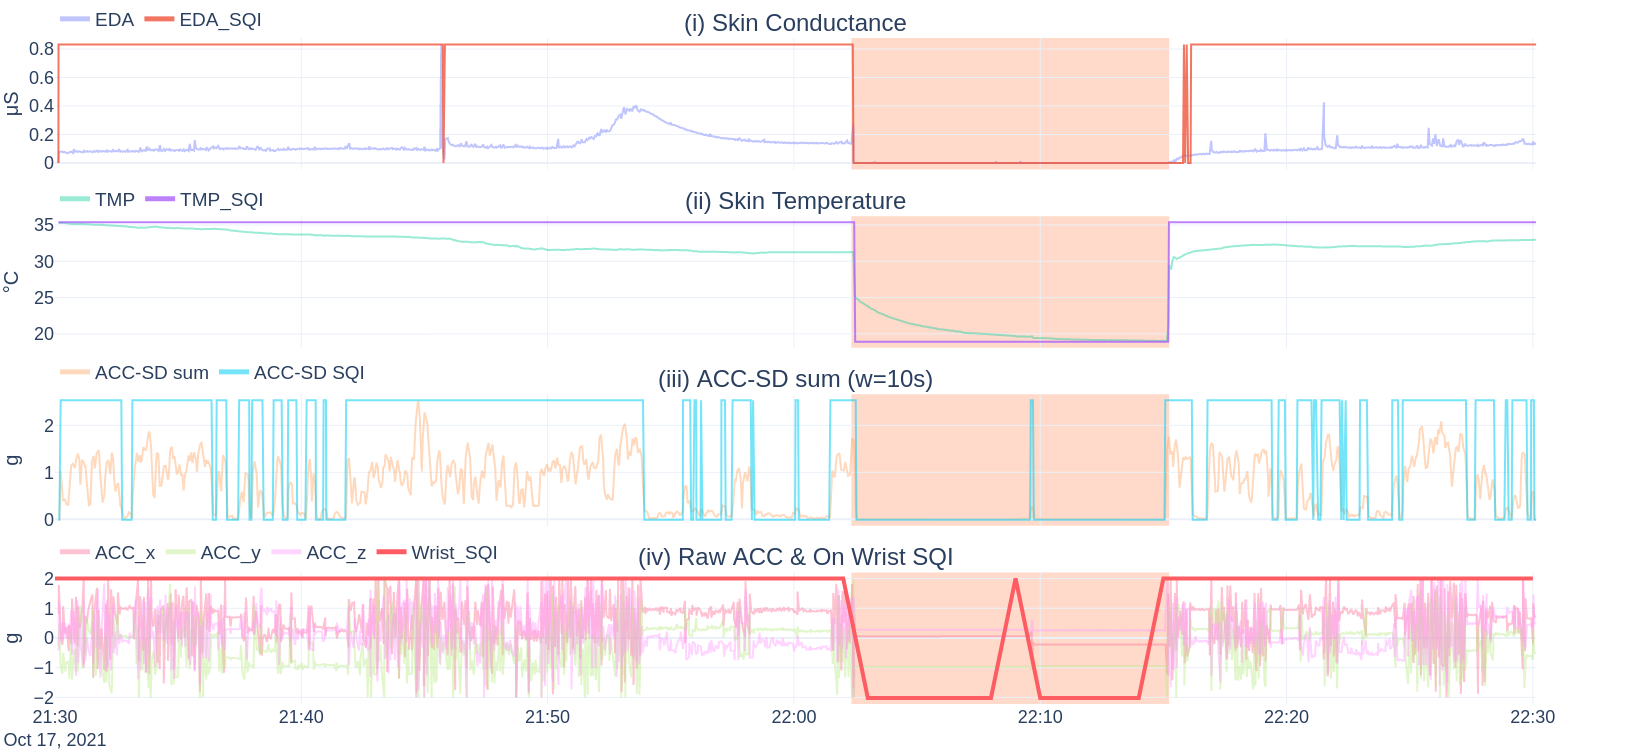

In [7]:
n_rows = 4
if True:
    specs = [[{"secondary_y": True}] for _ in range(n_rows)]
    fig = FigureResampler(
        make_subplots(
            rows=n_rows,
            specs=np.reshape(specs, (-1, 1)).tolist(),
            cols=1,
            shared_xaxes=True,
            subplot_titles=[
                "(i) Skin Conductance",
                "(ii) Skin Temperature",
                "(iii) ACC-SD sum (w=10s)",
                "(iv) Raw ACC & On Wrist SQI",
            ],
            vertical_spacing=0.07,
        ),
        show_mean_aggregation_size=False,
        resampled_trace_prefix_suffix=("", ""),
    )

fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=4, col=1)
fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=3, col=1)
fig.update_yaxes(range=[-0.05, 1.05], secondary_y=True, row=2, col=1)

# ROW 1 -----------------------------------------------------
for col in df_eda.columns:
    s_c = df_eda[col]
    fig.add_trace(go.Scatter(name=col, opacity=0.4), hf_x=s_c.index, hf_y=s_c)


for col in ["EDA_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
    )

# ROW 2 -----------------------------------------------------
for col in df_tmp.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, legend="legend2"),
        hf_x=df_tmp[col].index,
        hf_y=df_tmp[col],
        row=2,
        col=1,
    )


for col in ["TMP_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, opacity=0.8, legend="legend2"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
        secondary_y=True,
    )

# ROW 3 -----------------------------------------------------
for col in ["AI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name="ACC-SD sum", opacity=0.4, legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c,
        row=3,
        col=1,
    )

for col in ["AI_SQI"]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name="ACC-SD SQI", opacity=0.6, line_width=2, legend="legend3"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        row=3,
        col=1,
    )


# ROW 4 -----------------------------------------------------
for col in df_acc.columns:
    fig.add_trace(
        go.Scatter(name=col, opacity=0.4, legend="legend4"),
        hf_x=df_acc[col].index,
        hf_y=df_acc[col] / 64,
        row=4,
        col=1,
    )

for col, row_idx in [("EDA_SQI_mean", 1), ("AI_SQI_mean", 3), ("TMP_SQI_mean", 2)][:0]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name=col, legend="legend" + {2: "2", 3: "3", 4: "4"}.get(row_idx, "")
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=row_idx,
        col=1,
        secondary_y=True,
        limit_to_view=True,
    )


# ROW 4 -----------------------------------------------------
for col, row_idx in [ ("On_Wrist_SQI", 4)]:
    s_c = seq(out_bottcher).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(
            name='Wrist_SQI',
            line_width=4 if "wrist_sqi" in col.lower() else 2,
            line_color="#fd5c63" if "wrist_sqi" in col.lower() else None,
            legend="legend" + {2: "2", 3: "3", 4: "4"}.get(row_idx, ""),
        ),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        secondary_y=True,
        limit_to_view=True,
        row=row_idx,
        col=1,
    )


# highlight the off-wrist period
fig.add_vrect(
    x0=off_wrist_start_end_ts[0],
    x1=off_wrist_start_end_ts[1],
    fillcolor="lightsalmon",
    opacity=0.4,
    line_width=0,
    layer="below",
    row="all",
    col=1,
)

# ------------------------- LAYOUT --------------------------------
fig.update_layout(template="plotly_white", height=750)
fig.update_layout(
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.05,
        xanchor="right",
        x=0.95,
        font_size=17,
        itemsizing="constant",
    )
)

fig.update_layout(template="plotly_white", height=750)
fig.update_layout(
    legend=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=1.0, x=0, itemsizing="constant"),
    ),
    legend2=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.73, x=0, itemsizing="constant"),
    ),
    legend3=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.47, x=0, itemsizing="constant"),
    ),
    legend4=dict(
        **dict(orientation="h", yanchor="bottom", xanchor="left", font_size=19),
        **dict(y=0.20, x=0, itemsizing="constant"),
    ),
)
fig.update_yaxes(title_text="μS", row=1, col=1, title_font_size=20)
fig.update_yaxes(title_text="°C", row=2, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=3, col=1, title_font_size=20)
fig.update_yaxes(title_text="g", row=4, col=1, title_font_size=20)

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.update_annotations(font_size=24)
fig.update_xaxes(tickfont_size=18)
fig.update_yaxes(tickfont_size=18)
fig.update_yaxes(visible=False, secondary_y=True)
if USE_PNG:
    fig.show(renderer="png", width=1650, height=750)
fig.write_html(figure_dir / 'on_wrist_botcher_.html', include_plotlyjs='cdn', full_html=False)


## Backtest on large bouts of labeled data

Through leveraging `plotly-resampler`, we can backtest both non weare detection algorithms on large bouts of time series data.

The data was labeled via the [label_off_wrist](2.0_Label_off_wrist.ipynb) notebook

In [8]:
# the labeled off wrist data
df_meta = pd.read_csv(
    mbrain_metadata_path / "off_wrist_labeled.csv", parse_dates=["start", "end"]
)
df_meta["start"] = df_meta["start"].dt.tz_localize("Europe/Brussels", ambiguous="NaT")
df_meta["end"] = df_meta["end"].dt.tz_localize("Europe/Brussels", ambiguous="NaT")
print(df_meta.shape)
df_meta = df_meta.dropna(subset=["start", "end"])
print(df_meta.shape)

# ensure that the start is before the end
start = df_meta[["start", "end"]].min(axis=1)
end = df_meta[["start", "end"]].max(axis=1)
df_meta["start"] = start
df_meta["end"] = end
assert all(df_meta["start"] <= df_meta["end"])

df_meta["duration"] = df_meta["end"] - df_meta["start"]
df_meta[df_meta.label == "off-wrist"].groupby("user")["duration"].agg(
    ["sum", "count"]
)


(135, 4)
(135, 4)


,sum,count
user,,
MBRAIN21-001,0 days 00:11:36.234000,7
MBRAIN21-002,0 days 15:13:51.657000,37
MBRAIN21-003,0 days 03:13:19.867000,15
MBRAIN21-004,1 days 00:53:39.256000,76


In [9]:
from typing import List
from pathlib import Path

obelisk_dir = processed_mbrain_path


def get_all_user_empatica_data(ptcpt_name, signal="gsr") -> pd.DataFrame:
    eligible_files: List[Path] = []
    for folder in obelisk_dir.glob(f"{ptcpt_name}.empatica.E4*"):
        eligible_files.extend(list(folder.glob(f"{signal}_*")))

    data = []
    for eligible_file in eligible_files:
        pqt = pd.read_parquet(eligible_file)
        if "timestamp" in pqt.columns:
            pqt.set_index("timestamp", inplace=True)
        if len(pqt):
            data.append(pqt)
    if len(data):
        out = pd.concat(data, copy=False).sort_index()
        return out[~out.index.duplicated()]
    else:
        return pd.DataFrame()


In [10]:
user = "MBRAIN21-004"  # fetch all the data of this user
e4_tmp = get_all_user_empatica_data(user, "tmp")
e4_ibi = get_all_user_empatica_data(user, "ibi")
e4_eda = get_all_user_empatica_data(user, "gsr")
e4_acc = get_all_user_empatica_data(user, "acc")
# e4_bvp = get_all_user_empatica_data(user, "bvp")


### Our SQI

In [11]:
out = wrist_pipeline.process(
    [e4_eda, e4_tmp, e4_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(e4_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)


/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning:

Logging file (wrist_on_off_.log) already exists. This file will be overwritten!



,function,series_names,duration
0,<lambda>,"(ACC_x,)",0 days 00:00:02.113948584
1,<lambda>,"(EDA,)",0 days 00:00:00.007200480
2,<lambda>,"(TMP,)",0 days 00:00:00.007188797
3,<lambda>,"(AI,)",0 days 00:00:00.008571386
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:02.338790894
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:02.144894600
6,sqi_or,"(EDA_SQI, TMP_SQI, AI_SQI)",0 days 00:00:00.030690670
7,sqi_smoothen,"(On_Wrist_SQI,)",0 days 00:00:00.360845804
8,sqi_smoothen,"(On_Wrist_SQI_smoothened,)",0 days 00:00:00.368681192


0.00632 seconds per hour


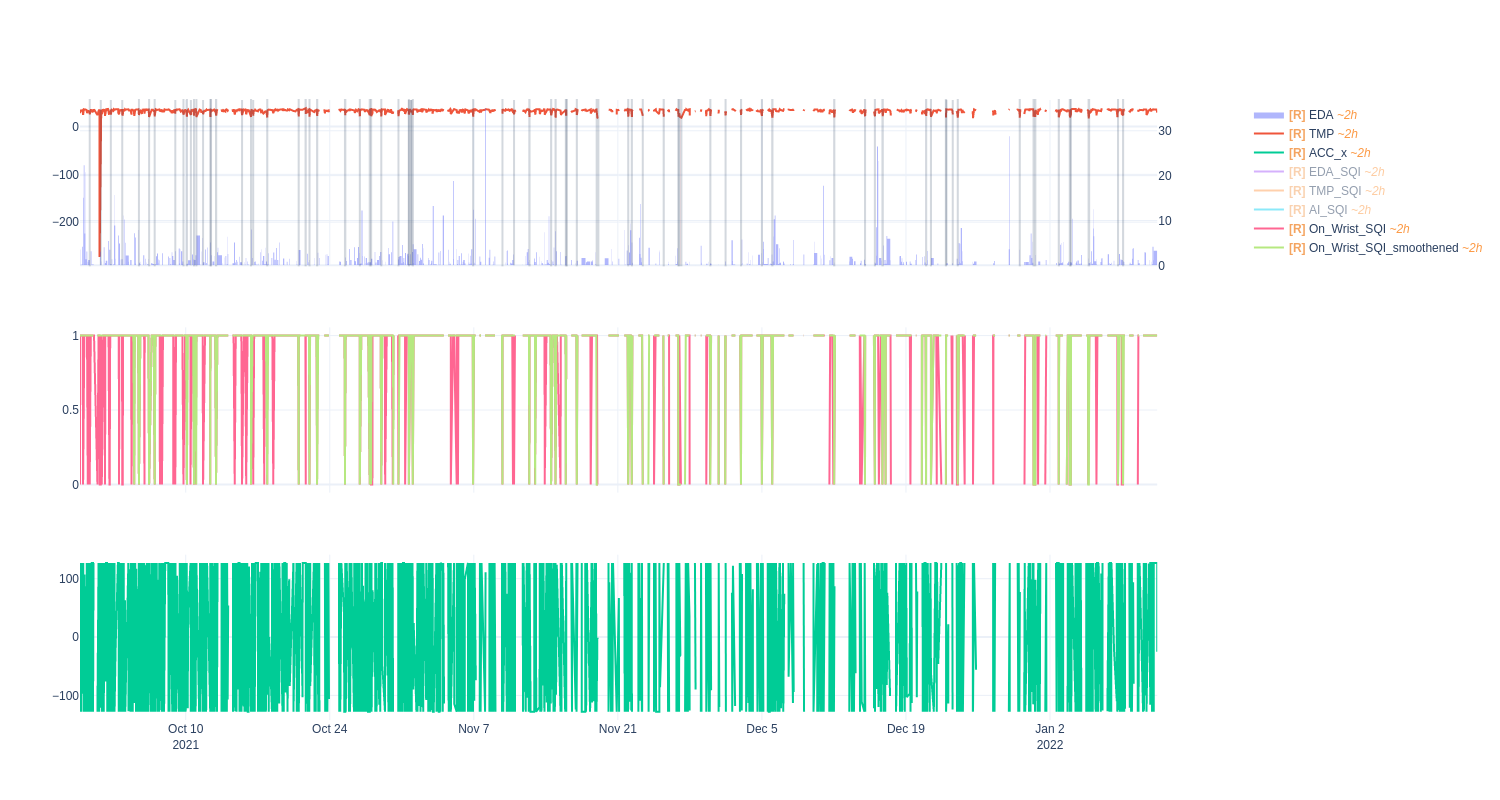

In [12]:
from plotly_resampler.aggregation import MinMaxLTTB
from plotly_resampler.aggregation.gap_handlers import MedDiffGapHandler

fig = FigureResampler(
    make_subplots(
        rows=3, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]] * 3
    ),
    default_downsampler=MinMaxLTTB(parallel=True),
)
# fmt: off
fig.add_trace(go.Scatter(name="EDA", opacity=0.5, fill='tozeroy', line_shape='vh', line_width=0), gap_handler=MedDiffGapHandler(fill_value=0), hf_x=e4_eda.index, hf_y=e4_eda["EDA"], row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(name="TMP"), hf_x=e4_tmp.index, hf_y=e4_tmp["TMP"], row=1, col=1)

fig.add_trace(go.Scatter(name='ACC_x'), hf_x=e4_acc.index, hf_y=e4_acc["ACC_x"], row=3, col=1)
# fig.add_trace(go.Scatter(name="BVP"), hf_x=e4_bvp.index, hf_y=e4_bvp["BVP"], row=3, col=1, secondary_y=True)

# fmt: on
for col in ["EDA_SQI", "TMP_SQI", "AI_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, visible="legendonly"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )
for col in ["On_Wrist_SQI", "On_Wrist_SQI_smoothened"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )

# fmt: off
for _, r in df_meta[(df_meta["user"] == user) & (df_meta.label == "off-wrist")].iterrows():
    fig.add_vrect(x0=r.start, x1=r.end, row=1, col=1, fillcolor="red", opacity=0.2)
fig.update_layout(template="plotly_white", height=800)
if USE_PNG:
    fig.show(renderer="png", width=1500)
fig.show_dash(mode="inline", port=8022)

### Bottcher

In [13]:
out = wrist_pipeline_bottcher.process(
    [e4_eda, e4_tmp, e4_acc],
    return_df=False,
    drop_keys=["ACC_x", "ACC_y", "ACC_z", "EDA"],
    logging_file_path="wrist_on_off_.log",
)
# display(out['Wrist_SQI_smoothened'].isna().value_counts())
# out['Wrist_SQI_smoothened'].bfill(inplace=True) #= out['Wrist_SQI_smoothened'].bfill()
pl = get_processor_logs("wrist_on_off_.log").drop(columns=["log_time"])
display(pl)  # , 'duration']))
print(
    round(pl.duration.sum().total_seconds() / (len(e4_eda) / (4 * 60 * 60)), 5),
    "seconds per hour",
)


/home/jonas/.cache/pypoetry/virtualenvs/data-quality-wearables-JR_qNb0v-py3.9/lib/python3.9/site-packages/tsflex/utils/logging.py:81: RuntimeWarning:

Logging file (wrist_on_off_.log) already exists. This file will be overwritten!



,function,series_names,duration
0,dataframe_func: std_sum,"(ACC_x, ACC_y, ACC_z)",0 days 00:00:28.766128540
1,<lambda>,"(AI,)",0 days 00:00:00.108652353
2,<lambda>,"(EDA,)",0 days 00:00:00.007476807
3,<lambda>,"(TMP,)",0 days 00:00:00.021178246
4,<lambda>,"(EDA_SQI, TMP_SQI)",0 days 00:00:00.112986565
5,<lambda>,"(EDA_SQI, AI_SQI)",0 days 00:00:25.333574772
6,mean_resample,"(EDA_SQI,)",0 days 00:00:00.756345272
7,mean_resample,"(AI_SQI,)",0 days 00:00:00.197948217
8,mean_resample,"(TMP_SQI,)",0 days 00:00:00.199582577
9,mean_resample,"(EDA_SQI,)",0 days 00:00:00.199701071


0.04804 seconds per hour


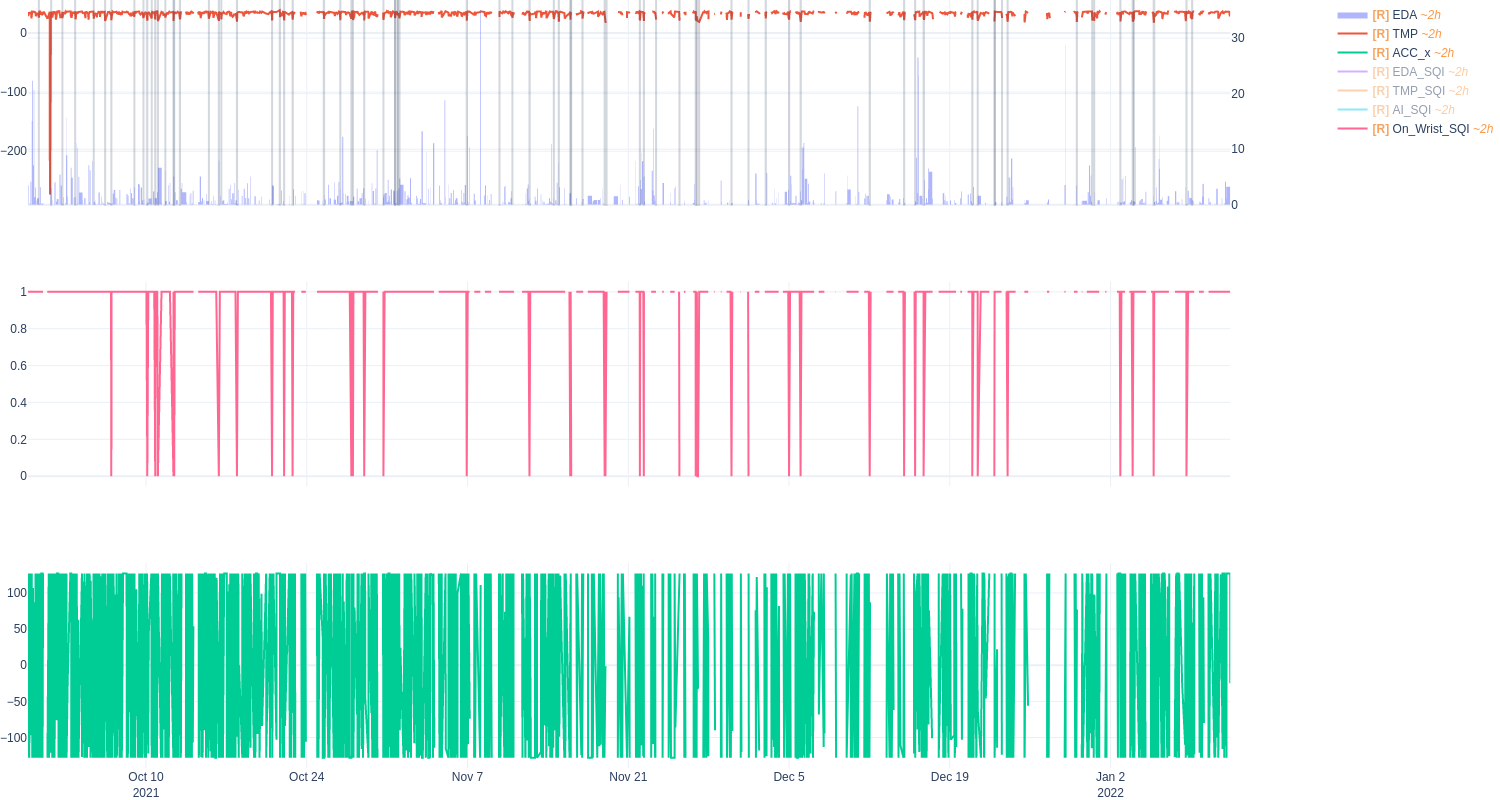

In [15]:
from plotly_resampler.aggregation import MinMaxLTTB
from plotly_resampler.aggregation.gap_handlers import MedDiffGapHandler

fig = FigureResampler(
    make_subplots(
        rows=3, cols=1, shared_xaxes=True, specs=[[{"secondary_y": True}]] * 3
    ),
    default_downsampler=MinMaxLTTB(parallel=True),
)
# fmt: off
fig.add_trace(go.Scatter(name="EDA", opacity=0.5, fill='tozeroy', line_shape='vh', line_width=0), gap_handler=MedDiffGapHandler(fill_value=0), hf_x=e4_eda.index, hf_y=e4_eda["EDA"], row=1, col=1, secondary_y=True)
fig.add_trace(go.Scatter(name="TMP"), hf_x=e4_tmp.index, hf_y=e4_tmp["TMP"], row=1, col=1)

fig.add_trace(go.Scatter(name='ACC_x'), hf_x=e4_acc.index, hf_y=e4_acc["ACC_x"], row=3, col=1)
# fig.add_trace(go.Scatter(name="BVP"), hf_x=e4_bvp.index, hf_y=e4_bvp["BVP"], row=3, col=1, secondary_y=True)

# fmt: on
for col in ["EDA_SQI", "TMP_SQI", "AI_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col, visible="legendonly"),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )
for col in ["On_Wrist_SQI"]:
    s_c = seq(out).filter(lambda x: x.name == col).to_list()[0]
    fig.add_trace(
        go.Scatter(name=col),
        hf_x=s_c.index,
        hf_y=s_c.astype(float),
        row=2,
        col=1,
    )

for _, r in df_meta[
    (df_meta["user"] == user) & (df_meta.label == "off-wrist")
].iterrows():
    fig.add_vrect(x0=r.start, x1=r.end, row=1, col=1, fillcolor="red", opacity=0.2)
fig.update_layout(template="plotly_white", height=800, margin=dict(l=0, r=0, t=0, b=0))
if USE_PNG:
    fig.show(renderer="png", width=1500)
fig.show_dash(mode="inline", port=8022)

## Validate both methods using metrics

In [13]:
from sklearn.metrics import classification_report
from code_utils.utils.dataframes import groupby_consecutive

from tqdm.auto import tqdm

Note: the code below can take some time as *all* data (e.g. ~90days) per paricipant is used to compute the metrics.

In [14]:
on_wrist_SQI_list, on_wrist_SQI_Bottcher_list = [], []

for user in tqdm(['001', '002', '003', '004']):
    user = 'MBRAIN21-' + user
    e4_tmp = get_all_user_empatica_data(user, "tmp")
    e4_ibi = get_all_user_empatica_data(user, "ibi")
    e4_eda = get_all_user_empatica_data(user, "gsr")
    e4_acc = get_all_user_empatica_data(user, "acc")

    on_wrist_SQI = (
        seq(wrist_pipeline.process([e4_eda, e4_tmp, e4_acc], return_all_series=False))
        .filter(lambda x: x.name == "On_Wrist_SQI_smoothened")
        .to_list()[0]
        .rename("On_Wrist_SQI")
        .to_frame()
    )

    # We resample the on-wrist SQI to 1 minute intervals (as this is the case for the
    # BOTTCHER SQI
    # If you comment out the following two lines, our on-wrist SQI score would even
    # lie higher! :)
    on_wrist_SQI.index = on_wrist_SQI.index.round("1min", ambiguous="NaT")
    on_wrist_SQI = on_wrist_SQI[
        ~on_wrist_SQI.index.duplicated(keep="first") & on_wrist_SQI.index.notna()
    ]

    on_wrist_SQI_Bottcher = (
        seq(wrist_pipeline_bottcher.process([e4_eda, e4_tmp, e4_acc], return_df=False, return_all_series=False))
        .filter(lambda x: x.name == "On_Wrist_SQI")
        .to_list()[0]
        .to_frame()
    )
    del e4_tmp, e4_ibi, e4_eda, e4_acc

    # Add the label and user information to both SQI's
    on_wrist_SQI["label"] = True
    on_wrist_SQI["user"] = user

    on_wrist_SQI_Bottcher["label"] = True
    on_wrist_SQI_Bottcher["user"] = user

    # Loop over the off-wrist labels which are longer than 1 minute
    for _, r in df_meta[
        (df_meta["user"] == user)
        & (df_meta.label == "off-wrist")
        & (df_meta.duration > pd.Timedelta("1min"))
    ].iterrows():
        on_wrist_SQI.loc[r.start : r.end, "label"] = False
        on_wrist_SQI_Bottcher.loc[r.start : r.end, "label"] = False

    # Assign an (equal) weight to each consecutive period of on-wrist
    # i.e. ensure that the sum of all period samples is one
    # This should ensure that short off-wrist periods are not underrepresented
    # compared to long off-wrist periods
    groups = groupby_consecutive(on_wrist_SQI["label"])
    groups["weight"] = 1 / groups["n_consecutive"]
    on_wrist_SQI["weight"] = None
    for _, r in groups.iterrows():
        on_wrist_SQI.loc[r.start : r.end, "weight"] = r.weight
    on_wrist_SQI["weight"] = on_wrist_SQI["weight"].astype(float)

    groups = groupby_consecutive(on_wrist_SQI_Bottcher["label"])
    groups["weight"] = 1 / groups["n_consecutive"]
    on_wrist_SQI_Bottcher["weight"] = None
    for _, r in groups.iterrows():
        on_wrist_SQI_Bottcher.loc[r.start : r.end, "weight"] = r.weight
    on_wrist_SQI_Bottcher["weight"] = on_wrist_SQI_Bottcher["weight"].astype(float)

    on_wrist_SQI_list.append(on_wrist_SQI)
    on_wrist_SQI_Bottcher_list.append(on_wrist_SQI_Bottcher)

on_wrist_SQI = pd.concat(on_wrist_SQI_list)
on_wrist_SQI_Bottcher = pd.concat(on_wrist_SQI_Bottcher_list)

  0%|          | 0/4 [00:00<?, ?it/s]

`Ours`

In [15]:
print(
    classification_report(
        on_wrist_SQI["On_Wrist_SQI"],
        on_wrist_SQI["label"],
        sample_weight=on_wrist_SQI["weight"],
    )
)
print(classification_report(on_wrist_SQI["On_Wrist_SQI"], on_wrist_SQI["label"]))


              precision    recall  f1-score   support

       False       0.89      0.98      0.93 99.6878014693585
        True       0.98      0.91      0.94 122.31219853067991

    accuracy                           0.94 222.00000000003843
   macro avg       0.94      0.94      0.94 222.00000000003843
weighted avg       0.94      0.94      0.94 222.00000000003843

              precision    recall  f1-score   support

       False       0.95      0.74      0.83      3371
        True       1.00      1.00      1.00    271230

    accuracy                           1.00    274601
   macro avg       0.98      0.87      0.91    274601
weighted avg       1.00      1.00      1.00    274601



`Böttcher`

In [16]:
print(
    classification_report(
        on_wrist_SQI_Bottcher["On_Wrist_SQI"],
        on_wrist_SQI_Bottcher["label"],
        sample_weight=on_wrist_SQI_Bottcher["weight"],
    )
)
print(
    classification_report(
        on_wrist_SQI_Bottcher["On_Wrist_SQI"],
        on_wrist_SQI_Bottcher["label"],
    )
)

              precision    recall  f1-score   support

       False       0.45      1.00      0.62 49.361749828381015
        True       1.00      0.65      0.79 171.63825017181648

    accuracy                           0.73 221.0000000001975
   macro avg       0.73      0.83      0.71 221.0000000001975
weighted avg       0.88      0.73      0.75 221.0000000001975

              precision    recall  f1-score   support

       False       0.65      1.00      0.79      1684
        True       1.00      1.00      1.00    273160

    accuracy                           1.00    274844
   macro avg       0.82      1.00      0.89    274844
weighted avg       1.00      1.00      1.00    274844

